In [1]:
#import imgaug.augmenters as iaa
import numpy as np
import random
import time
import cv2
import cupy as cp
import cupyx as cpx
import math
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from scipy.ndimage import zoom as scizoom
from cupyimg.skimage.transform import resize
from skimage.draw import line_aa

In [6]:
def rain_cupy(x, severity=1):
    c = [(1, 0.4),
         (0.8, 0.6),
         (0.7, 0.7),
         (0.65, 0.7),
         (0.6, 0.75)][severity - 1]
    frost = cv2.imread('./rain/rain1.png')
    frost_shape = frost.shape
    x_shape = cp.array(x).shape

    # resize the frost image so it fits to the image dimensions
    scaling_factor = 1
    if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = 1
    elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = x_shape[0] / frost_shape[0]
    elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
        scaling_factor = x_shape[1] / frost_shape[1]
    elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
        1]:  # If both dims are too small, pick the bigger scaling factor
        scaling_factor_0 = x_shape[0] / frost_shape[0]
        scaling_factor_1 = x_shape[1] / frost_shape[1]
        scaling_factor = cp.maximum(scaling_factor_0, scaling_factor_1)

    scaling_factor *= 1.1
    new_shape = (int(cp.ceil(frost_shape[1] * scaling_factor)),
                 int(cp.ceil(frost_shape[0] * scaling_factor)))
    frost_rescaled = cp.array(cv2.resize(frost, dsize=new_shape,
                                interpolation=cv2.INTER_CUBIC))

    # randomly crop
    x_start, y_start = np.random.randint(0, frost_rescaled.shape[0] - x_shape[
        0]), np.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

    if len(x_shape) < 3 or x_shape[2] < 3:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]]
        frost_rescaled = rgb2gray_cupy(frost_rescaled)
    else:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]][..., [2, 1, 0]]
        
    return np.clip(c[0] * cp.array(x) + c[1] * frost_rescaled, 0, 255)

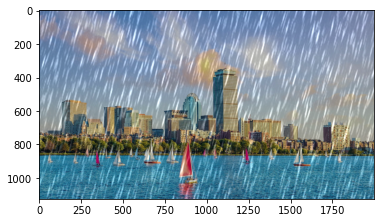

In [7]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/2.png'),cv2.COLOR_BGR2RGB)
out = np.uint8(cp.asnumpy(rain_cupy(img ,3)))

plt.imshow(out)